## 데이터 수집

In [61]:
from google.cloud import bigquery
from google.cloud.bigquery import job
from google.cloud.bigquery import SchemaField
import pandas as pd
import datetime as dt
import os
from datetime import datetime
pd.options.display.max_columns = None
from matplotlib import pyplot as plt
import seaborn as sns
from upsetplot import UpSet
from upsetplot import from_memberships
from tqdm import tqdm
import pygsheets


In [46]:


PROJECT = 'ballosodeuk'
client = bigquery.Client(project=PROJECT)

def estimate_query_cost(client, query):
    job_config = bigquery.QueryJobConfig(
        dry_run=True,
        use_query_cache=False
    )
    query_job = client.query(query, job_config=job_config)
    bytes_processed = query_job.total_bytes_processed
    kb = round(bytes_processed / 1024, 2)
    gb = round(bytes_processed / (1024 ** 3), 2)
    print("예상 쿼리 용량: {} KB, ({} GB)".format(kb, gb))

def run_query(client, query):
    job_config = bigquery.QueryJobConfig()
    query_job = client.query(query, job_config=job_config)
    return query_job

In [77]:
query_name = "1009_rfm_branch_1"
file = f'../query/{query_name}.sql'
with open(file, 'r') as file:
    query = file.read()

# 쿼리가 비어있지 않은지 확인
if query.strip():
    try:
        estimate_query_cost(client, query)
    except Exception as e:
        print(f"쿼리 비용 추정 중 오류 발생: {str(e)}")
        print("쿼리의 처음 500자:")
        print(query[:500])
else:
    print("쿼리가 비어 있습니다. SQL 파일의 내용을 확인해 주세요.")

예상 쿼리 용량: 18113208.97 KB, (17.27 GB)


- 총 쿼리 한번에 돌리기

In [78]:
df = run_query(client,query).to_dataframe()

for col in df.columns:
    if df[col].dtype == 'dbdate':
        df[col] = df[col].astype(str)

# Parquet 파일로 저장
# df.to_parquet('./0301_1007.parquet')
df.to_parquet('./1001_1007.parquet')

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


- 청크 단위로 쿼리 돌리기

In [ ]:
import os
from datetime import datetime
from google.cloud import bigquery
import pandas as pd

def run_query_and_save_chunks(client, query, chunk_size=10000, output_folder='output'):
    os.makedirs(output_folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    query_job = client.query(query)
    
    chunk_files = []
    chunk_count = 0
    rows_iter = query_job.result(page_size=chunk_size)
    
    # 열 이름과 타입 가져오기
    schema = query_job.result().schema
    column_names = [field.name for field in schema]
    column_types = {field.name: field.field_type for field in schema}
    
    for page in rows_iter.pages:
        chunk_count += 1
        data = [list(row.values()) for row in page]
        
        # DataFrame 생성
        chunk_df = pd.DataFrame(data, columns=column_names)
        
        # 날짜 열 변환
        for col, col_type in column_types.items():
            if col_type == 'DATE' or col_type == 'DATETIME':
                chunk_df[col] = pd.to_datetime(chunk_df[col])
        
        filename = f"{output_folder}/chunk_{timestamp}_{chunk_count:04d}.parquet"
        chunk_df.to_parquet(filename, index=False)
        chunk_files.append(filename)
        
        print(f"청크 {chunk_count} 저장됨: {filename} (크기: {len(chunk_df)} 행)")
    
    print(f"총 {chunk_count}개의 청크가 저장되었습니다.")
    return chunk_files

# 쿼리 실행 및 청크 저장
chunk_files = run_query_and_save_chunks(client, query, chunk_size=4000, output_folder='coupang_data')

# 저장된 파일들을 하나의 DataFrame으로 읽기 (필요한 경우)
df = pd.concat([pd.read_parquet(file) for file in chunk_files], ignore_index=True)

In [38]:
import os
import pandas as pd

# 'coupang_data' 폴더 경로
folder_path = 'coupang_data'

# 폴더 내 모든 파일 목록 가져오기
files = os.listdir(folder_path)

# parquet 파일만 필터링
parquet_files = [f for f in files if f.endswith('.parquet')]

if parquet_files:
    # 모든 parquet 파일을 읽어서 리스트에 저장
    df_list = []
    for file in parquet_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_parquet(file_path)
        df_list.append(df)
        print(f"파일 '{file}' 읽기 완료 (크기: {df.shape})")
    
    # 모든 데이터프레임을 하나로 합치기
    combined_df = pd.concat(df_list, ignore_index=True)
    
    print(f"\n모든 파일을 성공적으로 읽고 합쳤습니다.")
    print(f"최종 데이터프레임 크기: {combined_df.shape}")
    print("\n최종 데이터프레임의 처음 몇 행:")
    print(combined_df.head())
    
    # 중복 행 확인 및 제거 (필요한 경우)
    duplicates = combined_df.duplicated().sum()
    if duplicates > 0:
        print(f"\n중복된 행 수: {duplicates}")
        combined_df = combined_df.drop_duplicates()
        print(f"중복 제거 후 데이터프레임 크기: {combined_df.shape}")
else:
    print("'coupang_data' 폴더에 parquet 파일이 없습니다.")

파일 'chunk_20241009_163742_0001.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0002.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0003.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0004.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0005.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0006.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0007.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0008.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0009.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0010.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0011.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0012.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0013.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0014.parquet' 읽기 완료 (크기: (4000, 79))
파일 'chunk_20241009_163742_0015.parquet' 읽기 완료 (크기: (255, 79))

모든 파일을 성공적으로 읽고 합쳤습니다.
최종 데이터프레임 크기: (56255, 79)

최종 데이

C:\Users\Owner\AppData\Local\Temp\ipykernel_20072\1771473439.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(df_list, ignore_index=True)


> 결과적으로 둘 다 맞고 메모리 크게 부하 없었음.
아무거나 써도 됨

## EDA

In [6]:
df= pd.read_parquet('./0301_1007.parquet')
# df= pd.read_parquet('./0901_1007.parquet')

df.fillna(0,inplace=True)
df.columns

Index(['User_ID', 'Platform', 'Reg_Dttm', 'Cum_Lifetime', 'Cum_Cost_Recent',
       'Cum_Cost_min', 'Avg_Daily_Cost_Period', 'Avg_Daily_Cost_Lifetime',
       'Monatary_Offerwall', 'Monatary_Network', 'Monatary_INL_Launcher',
       'Monatary_INL_Challenge', 'Monatary_INL_Quiz', 'Monatary_Dynamic',
       'Monatary_Total', 'Recency_Offerwall', 'Recency_Network',
       'Recency_INL_Launcher', 'Recency_INL_Challenge', 'Recency_INL_Quiz',
       'Recency_Dynamic', 'Recncy_Total', 'Recency_Total_NoAd',
       'Frequency_Offerwall', 'Frequency_Network', 'Frequency_INL_Launcher',
       'Frequency_INL_Challenge', 'Frequency_INL_Quiz', 'Frequency_Dynamic',
       'Frequency_Total', 'Frequency_Total_NoAd', 'Frequency_Offerwall_c',
       'Frequency_Network_c', 'Frequency_INL_Launcher_c',
       'Frequency_INL_Challenge_c', 'Frequency_INL_Quiz_c',
       'Frequency_Dynamic_c', 'Frequency_Total_c', 'Frequency_Total_NoAd_c',
       'Cost_기본걸음적립', 'Freq_기본걸음적립', 'Cost_버튼누르고바로지급', 'Freq_버튼누르고바로지급'

In [ ]:
df[[
    'User_ID', 'Cum_Lifetime', 'Cum_Cost_Recent','Cum_Cost_min', 'Avg_Daily_Cost_Period', 'Avg_Daily_Cost_Lifetime',
    'Monatary_INL_Launcher','Monatary_INL_Challenge', 'Monatary_INL_Quiz', 'Monatary_Dynamic'
    ]]

1. 0301 ~ 1007


각 컬럼별 활성 유저 수:
Monatary_INL_Launcher: 13052
Monatary_INL_Challenge: 5390
Monatary_Dynamic: 44871
Monatary_INL_Quiz: 481
Monatary_INL_Launcher에 활성인 유저 수: 13052
Monatary_INL_Challenge에 활성인 유저 수: 5390
Monatary_Dynamic에 활성인 유저 수: 44871
Monatary_INL_Quiz에 활성인 유저 수: 481
Monatary_INL_Launcher 및 Monatary_INL_Challenge에 활성인 유저 수: 1064
Monatary_INL_Launcher 및 Monatary_Dynamic에 활성인 유저 수: 4563
Monatary_INL_Launcher 및 Monatary_INL_Quiz에 활성인 유저 수: 69
Monatary_INL_Challenge 및 Monatary_Dynamic에 활성인 유저 수: 2343
Monatary_INL_Challenge 및 Monatary_INL_Quiz에 활성인 유저 수: 30
Monatary_Dynamic 및 Monatary_INL_Quiz에 활성인 유저 수: 128
Monatary_INL_Launcher 및 Monatary_INL_Challenge 및 Monatary_Dynamic에 활성인 유저 수: 608
Monatary_INL_Launcher 및 Monatary_INL_Challenge 및 Monatary_INL_Quiz에 활성인 유저 수: 8
Monatary_INL_Launcher 및 Monatary_Dynamic 및 Monatary_INL_Quiz에 활성인 유저 수: 33
Monatary_INL_Challenge 및 Monatary_Dynamic 및 Monatary_INL_Quiz에 활성인 유저 수: 14
Monatary_INL_Launcher 및 Monatary_INL_Challenge 및 Monatary_Dynamic 및 Monatary_INL

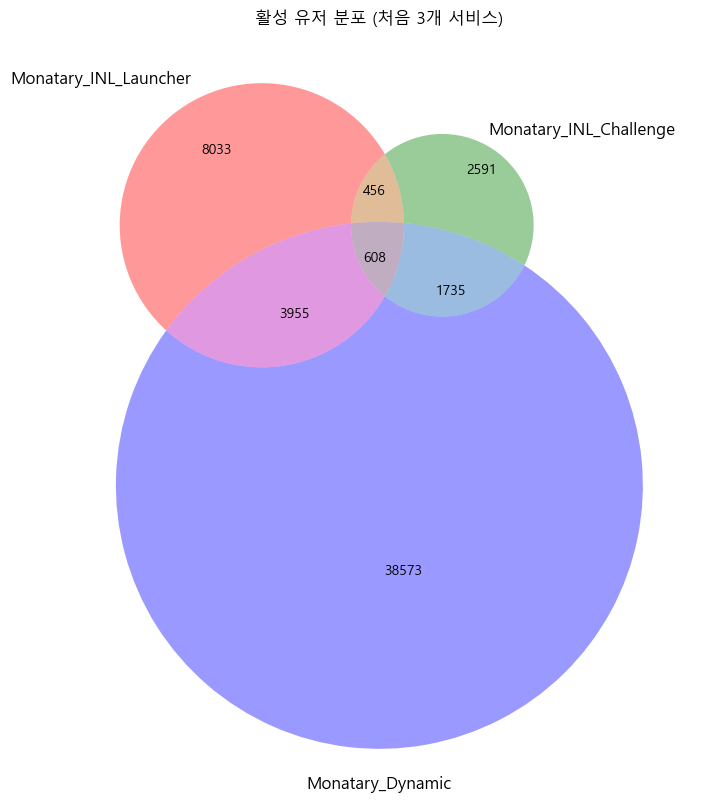


하나 이상의 컬럼에서 활성인 총 유저 수: 56255
모든 컬럼에서 활성인 유저 수: 5
Monatary_INL_Launcher에서만 활성인 유저 수: 8000
Monatary_INL_Challenge에서만 활성인 유저 수: 2578
Monatary_Dynamic에서만 활성인 유저 수: 38487
Monatary_INL_Quiz에서만 활성인 유저 수: 304


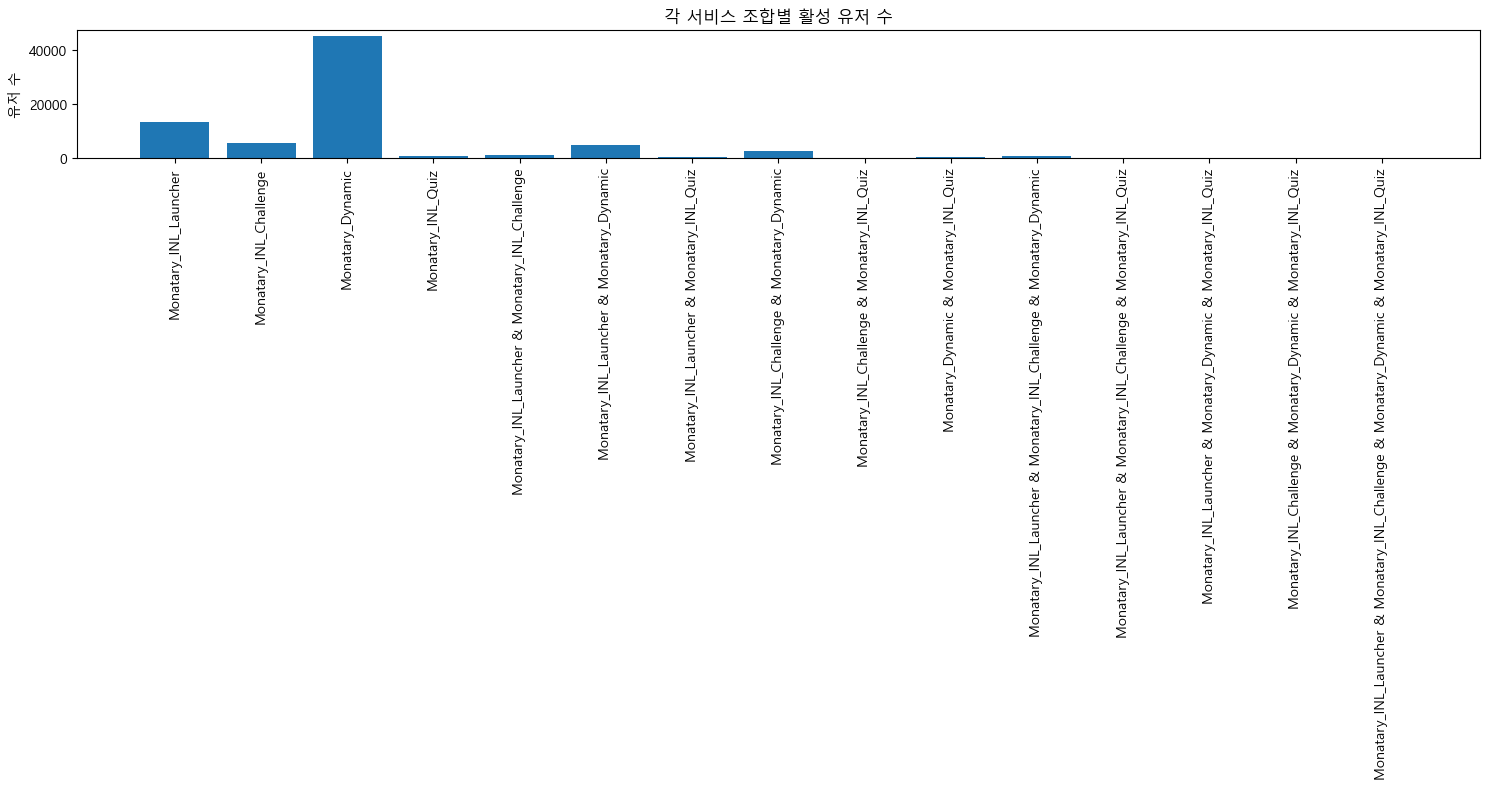

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
from itertools import combinations
import matplotlib.font_manager as fm

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕 폰트 경로
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 분석할 컬럼들
columns_of_interest = ['Monatary_INL_Launcher', 'Monatary_INL_Challenge','Monatary_Dynamic', 'Monatary_INL_Quiz']

# 각 컬럼에 대해 0이 아닌 값을 가진 유저 수 계산
users_per_column = {col: df[df[col] != 0]['User_ID'].nunique() for col in columns_of_interest}
users_per_column


print("각 컬럼별 활성 유저 수:")
for col, count in users_per_column.items():
    print(f"{col}: {count}")

# 이진 데이터프레임 생성
binary_df = (df[columns_of_interest] != 0).astype(int)
binary_df['User_ID'] = df['User_ID']

# 각 조합에 대한 유저 수 계산
combinations_count = {}
for r in range(1, len(columns_of_interest) + 1):
    for combo in combinations(columns_of_interest, r):
        count = binary_df[binary_df[list(combo)].all(axis=1)]['User_ID'].nunique()
        combinations_count[combo] = count
        print(f"{' 및 '.join(combo)}에 활성인 유저 수: {count}")

# 벤 다이어그램 그리기 (처음 3개 컬럼에 대해서만)
plt.figure(figsize=(10, 10))
venn3([set(df[df[col] != 0]['User_ID']) for col in columns_of_interest[:3]], 
      set_labels=columns_of_interest[:3])
plt.title("활성 유저 분포 (처음 3개 서비스)")
plt.show()

# 하나 이상의 컬럼에서 활성인 총 유저 수
total_active_users = binary_df[binary_df[columns_of_interest].any(axis=1)]['User_ID'].nunique()
print(f"\n하나 이상의 컬럼에서 활성인 총 유저 수: {total_active_users}")

# 모든 컬럼에서 활성인 유저 수
all_active_users = binary_df[binary_df[columns_of_interest].all(axis=1)]['User_ID'].nunique()
print(f"모든 컬럼에서 활성인 유저 수: {all_active_users}")

# 각 컬럼에서만 활성인 유저 수
for col in columns_of_interest:
    only_active = binary_df[
        (binary_df[col] == 1) & 
        (binary_df[columns_of_interest].drop(columns=[col]) == 0).all(axis=1)
    ]['User_ID'].nunique()
    print(f"{col}에서만 활성인 유저 수: {only_active}")

# 막대 그래프로 각 조합의 유저 수 시각화
plt.figure(figsize=(15, 8))
plt.bar(range(len(combinations_count)), combinations_count.values())
plt.xticks(range(len(combinations_count)), [' & '.join(k) for k in combinations_count.keys()], rotation=90)
plt.ylabel('유저 수')
plt.title('각 서비스 조합별 활성 유저 수')
plt.tight_layout()
plt.show()

2. 0901 ~ 1007

각 컬럼별 활성 유저 수:
Monatary_INL_Launcher: 10330
Monatary_INL_Challenge: 4406
Monatary_Dynamic: 11997
Monatary_INL_Quiz: 417
Monatary_INL_Launcher에 활성인 유저 수: 10330
Monatary_INL_Challenge에 활성인 유저 수: 4406
Monatary_Dynamic에 활성인 유저 수: 11997
Monatary_INL_Quiz에 활성인 유저 수: 417
Monatary_INL_Launcher 및 Monatary_INL_Challenge에 활성인 유저 수: 771
Monatary_INL_Launcher 및 Monatary_Dynamic에 활성인 유저 수: 1770
Monatary_INL_Launcher 및 Monatary_INL_Quiz에 활성인 유저 수: 49
Monatary_INL_Challenge 및 Monatary_Dynamic에 활성인 유저 수: 775
Monatary_INL_Challenge 및 Monatary_INL_Quiz에 활성인 유저 수: 23
Monatary_Dynamic 및 Monatary_INL_Quiz에 활성인 유저 수: 60
Monatary_INL_Launcher 및 Monatary_INL_Challenge 및 Monatary_Dynamic에 활성인 유저 수: 233
Monatary_INL_Launcher 및 Monatary_INL_Challenge 및 Monatary_INL_Quiz에 활성인 유저 수: 8
Monatary_INL_Launcher 및 Monatary_Dynamic 및 Monatary_INL_Quiz에 활성인 유저 수: 14
Monatary_INL_Challenge 및 Monatary_Dynamic 및 Monatary_INL_Quiz에 활성인 유저 수: 7
Monatary_INL_Launcher 및 Monatary_INL_Challenge 및 Monatary_Dynamic 및 Monatary_INL_Qui

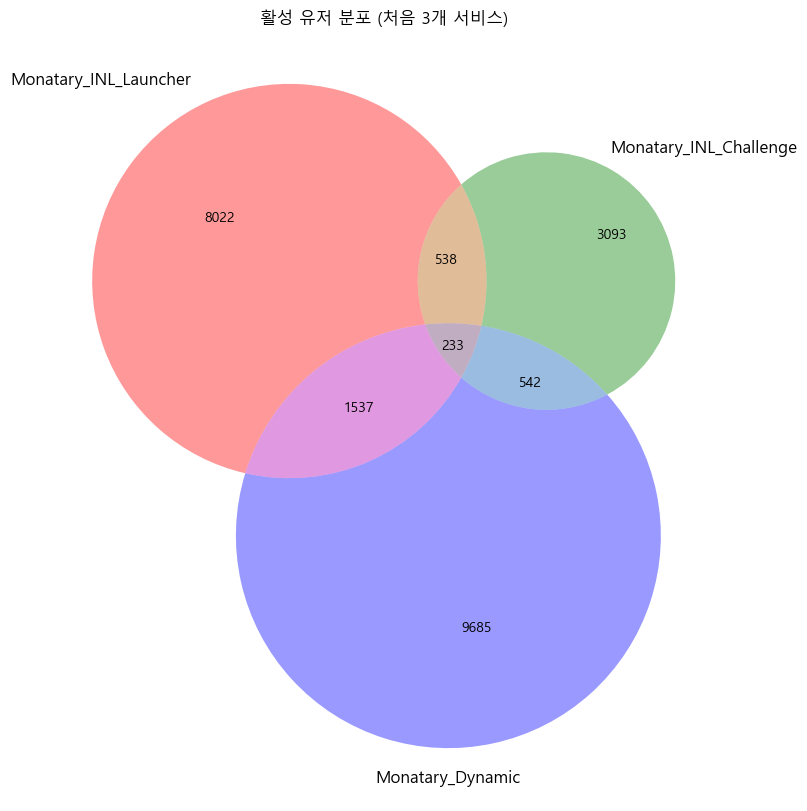


하나 이상의 컬럼에서 활성인 총 유저 수: 23960
모든 컬럼에서 활성인 유저 수: 4
Monatary_INL_Launcher에서만 활성인 유저 수: 7991
Monatary_INL_Challenge에서만 활성인 유저 수: 3081
Monatary_Dynamic에서만 활성인 유저 수: 9642
Monatary_INL_Quiz에서만 활성인 유저 수: 310


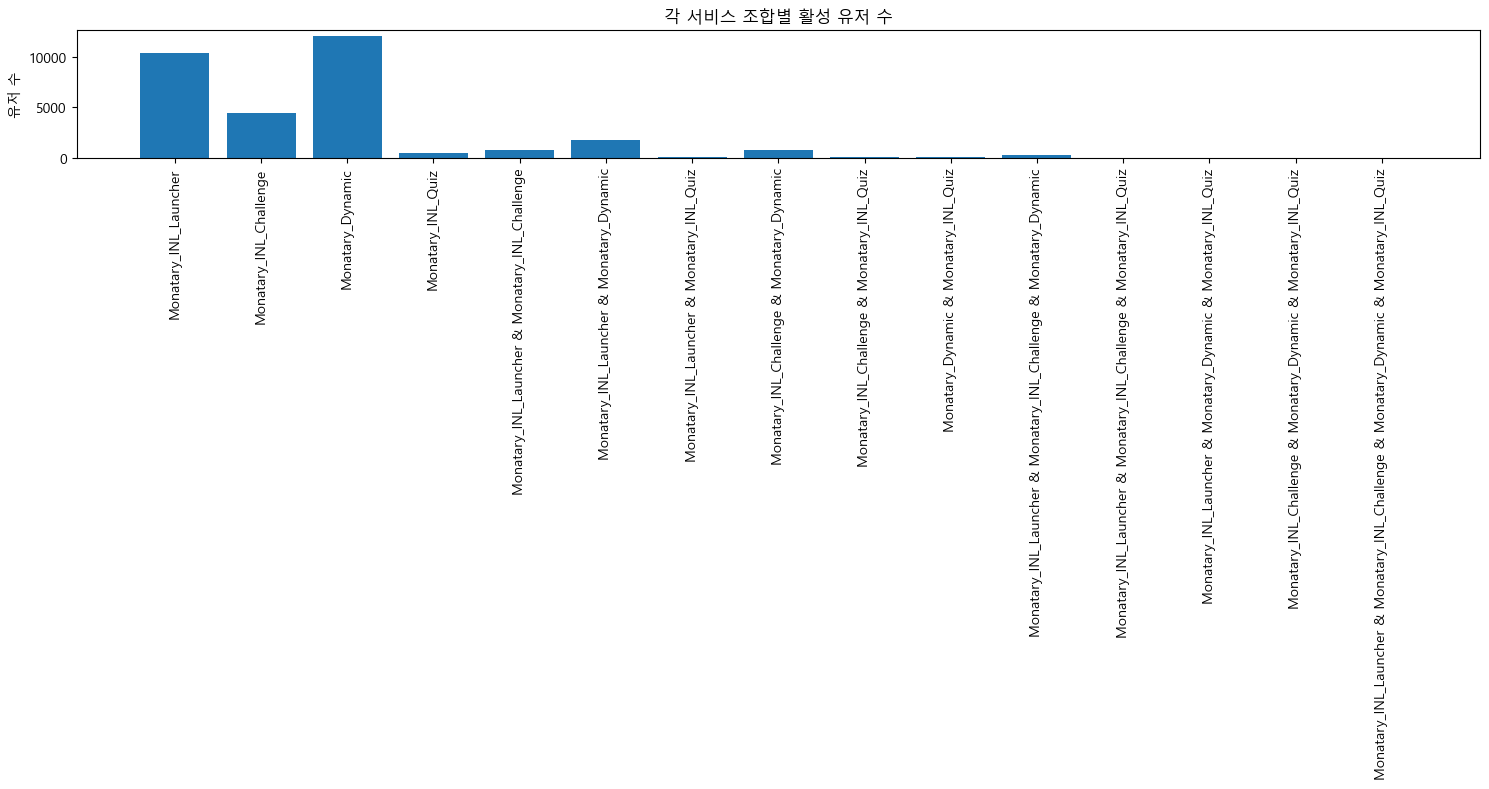

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
from itertools import combinations
import matplotlib.font_manager as fm

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕 폰트 경로
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 분석할 컬럼들
columns_of_interest = ['Monatary_INL_Launcher', 'Monatary_INL_Challenge','Monatary_Dynamic', 'Monatary_INL_Quiz']

# 각 컬럼에 대해 0이 아닌 값을 가진 유저 수 계산
users_per_column = {col: df[df[col] != 0]['User_ID'].nunique() for col in columns_of_interest}
users_per_column


print("각 컬럼별 활성 유저 수:")
for col, count in users_per_column.items():
    print(f"{col}: {count}")

# 이진 데이터프레임 생성
binary_df = (df[columns_of_interest] != 0).astype(int)
binary_df['User_ID'] = df['User_ID']

# 각 조합에 대한 유저 수 계산
combinations_count = {}
for r in range(1, len(columns_of_interest) + 1):
    for combo in combinations(columns_of_interest, r):
        count = binary_df[binary_df[list(combo)].all(axis=1)]['User_ID'].nunique()
        combinations_count[combo] = count
        print(f"{' 및 '.join(combo)}에 활성인 유저 수: {count}")

# 벤 다이어그램 그리기 (처음 3개 컬럼에 대해서만)
plt.figure(figsize=(10, 10))
venn3([set(df[df[col] != 0]['User_ID']) for col in columns_of_interest[:3]], 
      set_labels=columns_of_interest[:3])
plt.title("활성 유저 분포 (처음 3개 서비스)")
plt.show()

# 하나 이상의 컬럼에서 활성인 총 유저 수
total_active_users = binary_df[binary_df[columns_of_interest].any(axis=1)]['User_ID'].nunique()
print(f"\n하나 이상의 컬럼에서 활성인 총 유저 수: {total_active_users}")

# 모든 컬럼에서 활성인 유저 수
all_active_users = binary_df[binary_df[columns_of_interest].all(axis=1)]['User_ID'].nunique()
print(f"모든 컬럼에서 활성인 유저 수: {all_active_users}")

# 각 컬럼에서만 활성인 유저 수
for col in columns_of_interest:
    only_active = binary_df[ㅁ
        (binary_df[col] == 1) & 
        (binary_df[columns_of_interest].drop(columns=[col]) == 0).all(axis=1)
    ]['User_ID'].nunique()
    print(f"{col}에서만 활성인 유저 수: {only_active}")

# 막대 그래프로 각 조합의 유저 수 시각화
plt.figure(figsize=(15, 8))
plt.bar(range(len(combinations_count)), combinations_count.values())
plt.xticks(range(len(combinations_count)), [' & '.join(k) for k in combinations_count.keys()], rotation=90)
plt.ylabel('유저 수')
plt.title('각 서비스 조합별 활성 유저 수')
plt.tight_layout()
plt.show()

#### 겹치는 유저가 적음. 콘텐츠별로 분기 되어 있을 것이다.

각 API 별 고유 유저 분류 및 필터링

In [22]:
columns_of_interest = ['Recency_INL_Launcher', 'Recency_INL_Challenge', 'Recency_INL_Quiz', 'Recency_Dynamic']

unique_rev_users = []
for col in columns_of_interest:
    other_cols = [c for c in columns_of_interest if c != col]
    
    unique_users = df[
        (df[col] != 0) & 
        (df[other_cols] == 0).all(axis=1)
    ]['User_ID']

    unique_rev_users.append(unique_users)

# 각 시리즈의 고유 유저 수 출력
for i, users in enumerate(unique_rev_users):
    print(f"{columns_of_interest[i]}에 고유하게 존재하는 유저 수: {len(users)}")

# 모든 시리즈의 유저 ID를 하나의 리스트로 합치고 중복 제거
all_unique_users = list(set(user for users in unique_rev_users for user in users))

all_unique_users

Recency_INL_Launcher에 고유하게 존재하는 유저 수: 8000
Recency_INL_Challenge에 고유하게 존재하는 유저 수: 2578
Recency_INL_Quiz에 고유하게 존재하는 유저 수: 304
Recency_Dynamic에 고유하게 존재하는 유저 수: 38487


['77b38566-888f-4304-b3ff-1a29fb57702f',
 '0059ce68-e5ee-4ab4-8484-5434b19e2100',
 '34b17121-1226-4100-86f2-7af0c71fa73f',
 '2b3b17cf-7b90-48eb-9c44-9cb705bf6500',
 '9b83dc0b-75d9-42b4-a8b2-be3b93fb383c',
 'c224c26f-caf3-439f-ba32-ac6205851abd',
 'c5249b28-67ec-48e9-936d-41832787b37b',
 '8bd09938-f191-4bb5-a1ca-aeb79cced5f3',
 '35b06022-0b21-45cc-b7cb-f4597371e89e',
 'b6b140eb-2cbd-414e-99ef-b9c281e46ff0',
 '2330b920-8477-40b6-b392-87013e897b4f',
 '1f7423f9-e176-4353-bbac-e5580f31be9a',
 '0cfa82c6-6646-4845-94bf-8b8de5a6612b',
 '492c8450-d68d-4fa8-89e0-36672bf873d1',
 'cc01fb70-c897-4cbe-baa8-da4743e140a9',
 '0f674c27-230a-4201-8a28-6bdcfc0be0fd',
 '34e967e8-7d4f-4910-ae31-b31a9024f8be',
 '41f986e5-b49e-4589-8aec-4f4db0ed2902',
 '8edb80e5-984a-4da5-bce3-b85a0d3ec904',
 '4cbd801c-6cc2-424c-ad15-1b0a00c61929',
 'f9956dcb-ee71-42a9-8c59-417ef866cb80',
 '38e3a619-58ed-4c3b-96d0-6013cb994fd7',
 'f4d7bef8-ed04-4b06-b39c-d90174d21ced',
 '75723759-113c-4f71-94d5-b427da0e915d',
 '490a9a95-f3c9-

In [33]:
df_10 = df[df['User_ID'].isin(all_unique_users)]

df_10.columns

df_ft = df_10[['User_ID','Reg_Dttm', 'Cum_Lifetime', 'Cum_Cost_Recent','Cum_Cost_min', 'Avg_Daily_Cost_Period', 'Avg_Daily_Cost_Lifetime',
'Monatary_Offerwall', 'Monatary_Network', 
'Monatary_INL_Launcher','Monatary_INL_Challenge', 'Monatary_INL_Quiz', 'Monatary_Dynamic',
'Frequency_Offerwall_c','Frequency_Network_c', 'Frequency_INL_Launcher_c',
'Frequency_INL_Challenge_c', 'Frequency_INL_Quiz_c','Frequency_Dynamic_c',
'Freq_기본걸음적립','Freq_버튼누르고바로지급','Freq_와우회원설정','Freq_쿠팡와우회원설정','Freq_쿠팡에서추가','Freq_쿠팡','Freq_챌린지보상','Freq_보너스봉투','Freq_가위바위보','Freq_네트워크_애드파이_영상광고','Freq_자몽랩','Freq_애드팝콘','Freq_챌린지둘러보기','Freq_와이즈브릭스','Freq_골드레인','Freq_친구초대입력','Freq_아바티','Freq_박터뜨리기','Freq_핀크럭스','Freq_지원금보상']]

df_ft['cat'] = df_ft.apply(lambda x: 'Launcher' if x['Monatary_INL_Launcher'] > 0 
                           else 'Challenge' if x['Monatary_INL_Challenge'] > 0
                           else 'Quiz' if x['Monatary_INL_Quiz'] > 0
                           else 'Dynamic' if x['Monatary_Dynamic'] > 0
                           else 'None', 
                           axis=1)

C:\Users\Owner\AppData\Local\Temp\ipykernel_29804\2587480131.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ft['cat'] = df_ft.apply(lambda x: 'Launcher' if x['Monatary_INL_Launcher'] > 0


In [49]:
numeric_columns = df_ft.select_dtypes(include=['int64', 'float64']).columns
grouped_stats = df_ft.groupby('cat')[numeric_columns].agg(['mean', 'median', 'std', 'min', 'max'])
# 결과를 보기 좋게 정리
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2f}'.format)

grouped_stats


Cum_Lifetime                        Cum_Cost_Recent           \
                  mean median    std min  max            mean   median   
cat                                                                      
Challenge       365.51 379.00 138.09   0  631        50667.75 43089.00   
Dynamic         330.84 353.00 149.87   0  657        28001.54 15521.00   
Launcher        337.48 356.00 145.24   0  655        43218.70 36866.50   
Quiz            237.68 251.50 188.39   0  631        18991.91  2881.50   

                                     Cum_Cost_min                         \
                std  min         max         mean   median      std  min   
cat                                                                        
Challenge  68706.89 0.00  1843388.00     34639.17 30370.50 39119.42 0.00   
Dynamic   100406.35 0.00 15818531.00     19796.47 10431.00 45422.71 0.00   
Launcher   80055.46 0.00  5301079.00     28138.39 23005.50 44759.82 0.00   
Quiz       38722.26 0.00   346450.00     13694.01  1627.50 29561.91 0.00   

                     Avg_Daily_Cost_Period                              \
                 max                  mean median    std  min      max   
cat                                                                      
Challenge 1043044.00                 72.86  54.42 200.43 0.00  7785.42   
Dynamic   4339525.00                 37.30  14.94 312.35 0.00 55883.52   
Launcher  1850696.00                 68.55  55.14 210.72 0.00 15683.56   
Quiz       240712.00                 24.08   3.08  68.84 0.00   968.60   

          Avg_Daily_Cost_Lifetime                              \
                             mean median    std  min      max   
cat                                                             
Challenge                  138.04 116.97 184.53 0.00  5806.40   
Dynamic                     78.98  51.60 272.12 0.00 44559.24   
Launcher                   126.29 110.72 267.12 0.00 12742.98   
Quiz                        59.19  19.13  94.92 0.00   782.05   

          Monatary_Offerwall                               Monatary_Network  \
                        mean median     std  min       max             mean   
cat                                                                           
Challenge             797.46   0.00 5179.08 0.00 102381.75           539.87   
Dynamic               319.18   0.00 3879.06 0.00 357343.78           398.10   
Launcher             1107.62   1.69 9212.26 0.00 617217.16           658.18   
Quiz                  896.34   0.00 8514.66 0.00 140654.85           211.07   

                                     Monatary_INL_Launcher                  \
          median    std  min     max                  mean  median     std   
cat                                                                          
Challenge 324.00 590.76 0.00 4356.00                  0.00    0.00    0.00   
Dynamic   244.80 453.71 0.00 4413.60                  0.00    0.00    0.00   
Launcher  468.00 626.37 0.00 5292.00               2176.15 1190.00 4396.44   
Quiz       43.20 428.21 0.00 3456.00                  0.00    0.00    0.00   

                         Monatary_INL_Challenge                                \
           min       max                   mean  median     std  min      max   
cat                                                                             
Challenge 0.00      0.00                1788.20 1054.50 3201.30 5.00 74192.00   
Dynamic   0.00      0.00                   0.00    0.00    0.00 0.00     0.00   
Launcher  4.00 167434.00                   0.00    0.00    0.00 0.00     0.00   
Quiz      0.00      0.00                   0.00    0.00    0.00 0.00     0.00   

          Monatary_INL_Quiz                              Monatary_Dynamic  \
                       mean median     std  min      max             mean   
cat                                                                         
Challenge              0.00   0.00    0.00 0.00     0.00             0.00   
Dynami

- 부트스트래핑으로 로그데이터 한계 극복

In [123]:
import numpy as np
from scipy import stats
from tqdm import tqdm

# 랜덤 시드 설정
np.random.seed(42)  # 42는 임의의 숫자입니다. 원하는 다른 정수로 변경 가능합니다.

def bootstrap_mean_ci(data, n_bootstrap=5000, ci=0.95):
    bootstrap_means = np.array([np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstrap)])
    return round(np.mean(data), 2), (round(np.percentile(bootstrap_means, (1-ci)/2*100), 2), 
                                     round(np.percentile(bootstrap_means, (1+ci)/2*100), 2))

results = {}
for cat in tqdm(df_ft['cat'].unique(), desc="카테고리 처리 중"):
    cat_data = df_ft[df_ft['cat'] == cat]
    results[cat] = {}
    for col in tqdm(numeric_columns, desc=f"{cat} 열 처리 중", leave=False):
        mean, (ci_lower, ci_upper) = bootstrap_mean_ci(cat_data[col].dropna())
        results[cat][col] = {'m': round(mean, 2), 'l': round(ci_lower, 2), 'u': round(ci_upper, 2)}

# 결과 출력
for cat, cat_results in results.items():
    print(f"\n{cat}:")
    for col, stats in cat_results.items():
        print(f"  {col}: 평균 = {stats['m']:.2f}, 95% CI = ({stats['l']:.2f}, {stats['u']:.2f})")

카테고리 처리 중: 100%|██████████| 4/4 [02:02<00:00, 30.67s/it]


Dynamic:
  Cum_Lifetime: 평균 = 330.84, 95% CI = (329.30, 332.35)
  Cum_Cost_Recent: 평균 = 28001.54, 95% CI = (27155.30, 29160.32)
  Cum_Cost_min: 평균 = 19796.47, 95% CI = (19366.22, 20282.48)
  Avg_Daily_Cost_Period: 평균 = 37.30, 95% CI = (34.95, 40.90)
  Avg_Daily_Cost_Lifetime: 평균 = 78.98, 95% CI = (76.73, 82.12)
  Monatary_Offerwall: 평균 = 319.18, 95% CI = (281.75, 360.16)
  Monatary_Network: 평균 = 398.10, 95% CI = (393.60, 402.70)
  Monatary_INL_Launcher: 평균 = 0.00, 95% CI = (0.00, 0.00)
  Monatary_INL_Challenge: 평균 = 0.00, 95% CI = (0.00, 0.00)
  Monatary_INL_Quiz: 평균 = 0.00, 95% CI = (0.00, 0.00)
  Monatary_Dynamic: 평균 = 2414.51, 95% CI = (2373.76, 2457.60)
  Frequency_Offerwall_c: 평균 = 3.81, 95% CI = (3.66, 3.96)
  Frequency_Network_c: 평균 = 55.29, 95% CI = (54.66, 55.90)
  Frequency_INL_Launcher_c: 평균 = 0.00, 95% CI = (0.00, 0.00)
  Frequency_INL_Challenge_c: 평균 = 0.00, 95% CI = (0.00, 0.00)
  Frequency_INL_Quiz_c: 평균 = 0.00, 95% CI = (0.00, 0.00)
  Frequency_Dynamic_c: 평균 = 1.55, 95

In [125]:
pd.DataFrame(results)

,Dynamic,Launcher,Challenge,Quiz
Cum_Lifetime,"{'m': 330.84, 'l': 329.3, 'u': 332.35}","{'m': 337.48, 'l': 334.21, 'u': 340.55}","{'m': 365.51, 'l': 360.24, 'u': 370.75}","{'m': 237.68, 'l': 216.37, 'u': 259.31}"
Cum_Cost_Recent,"{'m': 28001.54, 'l': 27155.3, 'u': 29160.32}","{'m': 43218.7, 'l': 41651.03, 'u': 45083.35}","{'m': 50667.75, 'l': 48171.55, 'u': 53530.22}","{'m': 18991.91, 'l': 14959.28, 'u': 23464.45}"
Cum_Cost_min,"{'m': 19796.47, 'l': 19366.22, 'u': 20282.48}","{'m': 28138.39, 'l': 27226.18, 'u': 29131.39}","{'m': 34639.17, 'l': 33226.99, 'u': 36225.15}","{'m': 13694.01, 'l': 10617.67, 'u': 17146.13}"
Avg_Daily_Cost_Period,"{'m': 37.3, 'l': 34.95, 'u': 40.9}","{'m': 68.55, 'l': 64.68, 'u': 73.82}","{'m': 72.86, 'l': 66.26, 'u': 81.95}","{'m': 24.08, 'l': 17.42, 'u': 33.02}"
Avg_Daily_Cost_Lifetime,"{'m': 78.98, 'l': 76.73, 'u': 82.12}","{'m': 126.29, 'l': 120.85, 'u': 132.43}","{'m': 138.04, 'l': 131.49, 'u': 145.69}","{'m': 59.19, 'l': 48.94, 'u': 70.8}"
Monatary_Offerwall,"{'m': 319.18, 'l': 281.75, 'u': 360.16}","{'m': 1107.62, 'l': 931.03, 'u': 1328.95}","{'m': 797.46, 'l': 608.07, 'u': 1012.3}","{'m': 896.34, 'l': 220.27, 'u': 2061.68}"
Monatary_Network,"{'m': 398.1, 'l': 393.6, 'u': 402.7}","{'m': 658.18, 'l': 644.42, 'u': 672.28}","{'m': 539.87, 'l': 517.24, 'u': 562.14}","{'m': 211.07, 'l': 165.1, 'u': 261.33}"
Monatary_INL_Launcher,"{'m': 0.0, 'l': 0.0, 'u': 0.0}","{'m': 2176.15, 'l': 2083.3, 'u': 2276.97}","{'m': 0.0, 'l': 0.0, 'u': 0.0}","{'m': 0.0, 'l': 0.0, 'u': 0.0}"
Monatary_INL_Challenge,"{'m': 0.0, 'l': 0.0, 'u': 0.0}","{'m': 0.0, 'l': 0.0, 'u': 0.0}","{'m': 1788.2, 'l': 1670.69, 'u': 1920.3}","{'m': 0.0, 'l': 0.0, 'u': 0.0}"
Monatary_INL_Quiz,"{'m': 0.0, 'l': 0.0, 'u': 0.0}","{'m': 0.0, 'l': 0.0, 'u': 0.0}","{'m': 0.0, 'l': 0.0, 'u': 0.0}","{'m': 1943.11, 'l': 1521.73, 'u': 2500.21}"


In [124]:
import pandas as pd
from itertools import combinations

# 결과를 DataFrame으로 변환하고 인덱스 리셋
df_results = pd.DataFrame(results).T.reset_index()
df_results = df_results.rename(columns={'index': 'feature'})

# 카테고리(군집) 확인
categories = df_results.columns[1:].tolist()
print("카테고리:", categories)

# 차이 분석 함수
def analyze_difference(row, cat1, cat2):
    ci1 = (row[cat1]['l'], row[cat1]['u'])
    ci2 = (row[cat2]['l'], row[cat2]['u'])
    
    if ci1[1] < ci2[0] or ci2[1] < ci1[0]:
        return "차이 있음"
    else:
        return "차이 없음"

# 모든 카테고리 쌍에 대해 차이 분석 수행
for cat1, cat2 in combinations(categories, 2):
    col_name = f"{cat1} vs {cat2}"
    df_results[col_name] = df_results.apply(lambda row: analyze_difference(row, cat1, cat2), axis=1)
    
df_results

카테고리: ['Cum_Lifetime', 'Cum_Cost_Recent', 'Cum_Cost_min', 'Avg_Daily_Cost_Period', 'Avg_Daily_Cost_Lifetime', 'Monatary_Offerwall', 'Monatary_Network', 'Monatary_INL_Launcher', 'Monatary_INL_Challenge', 'Monatary_INL_Quiz', 'Monatary_Dynamic', 'Frequency_Offerwall_c', 'Frequency_Network_c', 'Frequency_INL_Launcher_c', 'Frequency_INL_Challenge_c', 'Frequency_INL_Quiz_c', 'Frequency_Dynamic_c', 'Freq_기본걸음적립', 'Freq_버튼누르고바로지급', 'Freq_와우회원설정', 'Freq_쿠팡와우회원설정', 'Freq_쿠팡에서추가', 'Freq_쿠팡', 'Freq_챌린지보상', 'Freq_보너스봉투', 'Freq_가위바위보', 'Freq_네트워크_애드파이_영상광고', 'Freq_자몽랩', 'Freq_애드팝콘', 'Freq_챌린지둘러보기', 'Freq_와이즈브릭스', 'Freq_골드레인', 'Freq_친구초대입력', 'Freq_아바티', 'Freq_박터뜨리기', 'Freq_핀크럭스', 'Freq_지원금보상']


C:\Users\Owner\AppData\Local\Temp\ipykernel_29804\1628361018.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[col_name] = df_results.apply(lambda row: analyze_difference(row, cat1, cat2), axis=1)
C:\Users\Owner\AppData\Local\Temp\ipykernel_29804\1628361018.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[col_name] = df_results.apply(lambda row: analyze_difference(row, cat1, cat2), axis=1)
C:\Users\Owner\AppData\Local\Temp\ipykernel_29804\1628361018.py:25: PerformanceWarning: DataFrame is highly frag

,feature,Cum_Lifetime,Cum_Cost_Recent,Cum_Cost_min,Avg_Daily_Cost_Period,Avg_Daily_Cost_Lifetime,Monatary_Offerwall,Monatary_Network,Monatary_INL_Launcher,Monatary_INL_Challenge,Monatary_INL_Quiz,Monatary_Dynamic,Frequency_Offerwall_c,Frequency_Network_c,Frequency_INL_Launcher_c,Frequency_INL_Challenge_c,Frequency_INL_Quiz_c,Frequency_Dynamic_c,Freq_기본걸음적립,Freq_버튼누르고바로지급,Freq_와우회원설정,Freq_쿠팡와우회원설정,Freq_쿠팡에서추가,Freq_쿠팡,Freq_챌린지보상,Freq_보너스봉투,Freq_가위바위보,Freq_네트워크_애드파이_영상광고,Freq_자몽랩,Freq_애드팝콘,Freq_챌린지둘러보기,Freq_와이즈브릭스,Freq_골드레인,Freq_친구초대입력,Freq_아바티,Freq_박터뜨리기,Freq_핀크럭스,Freq_지원금보상,Cum_Lifetime vs Cum_Cost_Recent,Cum_Lifetime vs Cum_Cost_min,Cum_Lifetime vs Avg_Daily_Cost_Period,Cum_Lifetime vs Avg_Daily_Cost_Lifetime,Cum_Lifetime vs Monatary_Offerwall,Cum_Lifetime vs Monatary_Network,Cum_Lifetime vs Monatary_INL_Launcher,Cum_Lifetime vs Monatary_INL_Challenge,Cum_Lifetime vs Monatary_INL_Quiz,Cum_Lifetime vs Monatary_Dynamic,Cum_Lifetime vs Frequency_Offerwall_c,Cum_Lifetime vs Frequency_Network_c,Cum_Lifetime vs Frequency_INL_Launcher_c,Cum_Lifetime vs Frequency_INL_Challenge_c,Cum_Lifetime vs Frequency_INL_Quiz_c,Cum_Lifetime vs Frequency_Dynamic_c,Cum_Lifetime vs Freq_기본걸음적립,Cum_Lifetime vs Freq_버튼누르고바로지급,Cum_Lifetime vs Freq_와우회원설정,Cum_Lifetime vs Freq_쿠팡와우회원설정,Cum_Lifetime vs Freq_쿠팡에서추가,Cum_Lifetime vs Freq_쿠팡,Cum_Lifetime vs Freq_챌린지보상,Cum_Lifetime vs Freq_보너스봉투,Cum_Lifetime vs Freq_가위바위보,Cum_Lifetime vs Freq_네트워크_애드파이_영상광고,Cum_Lifetime vs Freq_자몽랩,Cum_Lifetime vs Freq_애드팝콘,Cum_Lifetime vs Freq_챌린지둘러보기,Cum_Lifetime vs Freq_와이즈브릭스,Cum_Lifetime vs Freq_골드레인,Cum_Lifetime vs Freq_친구초대입력,Cum_Lifetime vs Freq_아바티,Cum_Lifetime vs Freq_박터뜨리기,Cum_Lifetime vs Freq_핀크럭스,Cum_Lifetime vs Freq_지원금보상,Cum_Cost_Recent vs Cum_Cost_min,Cum_Cost_Recent vs Avg_Daily_Cost_Period,Cum_Cost_Recent vs Avg_Daily_Cost_Lifetime,Cum_Cost_Recent vs Monatary_Offerwall,Cum_Cost_Recent vs Monatary_Network,Cum_Cost_Recent vs Monatary_INL_Launcher,Cum_Cost_Recent vs Monatary_INL_Challenge,Cum_Cost_Recent vs Monatary_INL_Quiz,Cum_Cost_Recent vs Monatary_Dynamic,Cum_Cost_Recent vs Frequency_Offerwall_c,Cum_Cost_Recent vs Frequency_Network_c,Cum_Cost_Recent vs Frequency_INL_Launcher_c,Cum_Cost_Recent vs Frequency_INL_Challenge_c,Cum_Cost_Recent vs Frequency_INL_Quiz_c,Cum_Cost_Recent vs Frequency_Dynamic_c,Cum_Cost_Recent vs Freq_기본걸음적립,Cum_Cost_Recent vs Freq_버튼누르고바로지급,Cum_Cost_Recent vs Freq_와우회원설정,Cum_Cost_Recent vs Freq_쿠팡와우회원설정,Cum_Cost_Recent vs Freq_쿠팡에서추가,Cum_Cost_Recent vs Freq_쿠팡,Cum_Cost_Recent vs Freq_챌린지보상,Cum_Cost_Recent vs Freq_보너스봉투,Cum_Cost_Recent vs Freq_가위바위보,Cum_Cost_Recent vs Freq_네트워크_애드파이_영상광고,Cum_Cost_Recent vs Freq_자몽랩,Cum_Cost_Recent vs Freq_애드팝콘,Cum_Cost_Recent vs Freq_챌린지둘러보기,Cum_Cost_Recent vs Freq_와이즈브릭스,Cum_Cost_Recent vs Freq_골드레인,Cum_Cost_Recent vs Freq_친구초대입력,Cum_Cost_Recent vs Freq_아바티,Cum_Cost_Recent vs Freq_박터뜨리기,Cum_Cost_Recent vs Freq_핀크럭스,Cum_Cost_Recent vs Freq_지원금보상,Cum_Cost_min vs Avg_Daily_Cost_Period,Cum_Cost_min vs Avg_Daily_Cost_Lifetime,Cum_Cost_min vs Monatary_Offerwall,Cum_Cost_min vs Monatary_Network,Cum_Cost_min vs Monatary_INL_Launcher,Cum_Cost_min vs Monatary_INL_Challenge,Cum_Cost_min vs Monatary_INL_Quiz,Cum_Cost_min vs Monatary_Dynamic,Cum_Cost_min vs Frequency_Offerwall_c,Cum_Cost_min vs Frequency_Network_c,Cum_Cost_min vs Frequency_INL_Launcher_c,Cum_Cost_min vs Frequency_INL_Challenge_c,Cum_Cost_min vs Frequency_INL_Quiz_c,Cum_Cost_min vs Frequency_Dynamic_c,Cum_Cost_min vs Freq_기본걸음적립,Cum_Cost_min vs Freq_버튼누르고바로지급,Cum_Cost_min vs Freq_와우회원설정,Cum_Cost_min vs Freq_쿠팡와우회원설정,Cum_Cost_min vs Freq_쿠팡에서추가,Cum_Cost_min vs Freq_쿠팡,Cum_Cost_min vs Freq_챌린지보상,Cum_Cost_min vs Freq_보너스봉투,Cum_Cost_min vs Freq_가위바위보,Cum_Cost_min vs Freq_네트워크_애드파이_영상광고,Cum_Cost_min vs Freq_자몽랩,Cum_Cost_min vs Freq_애드팝콘,Cum_Cost_min vs Freq_챌린지둘러보기,Cum_Cost_min vs Freq_와이즈브릭스,Cum_Cost_min vs Freq_골드레인,Cum_Cost_min vs Freq_친구초대입력,Cum_Cost_min vs Freq_아바티,Cum_Cost_min vs Freq_박터뜨리기,Cum_Cost_min vs Freq_핀크럭스,Cum_Cost_min vs Freq_지원금보상,Avg_Da

### 결론, API 별 차이가 상당히 명료하다.
- 캐시버튼은 비-캐시버튼과 거리가 상당히 멀다. 특히, 캐시버튼과 바로가기의 차이가 극명하다.
- 재밌는 점은 캐시버튼과 퀴즈, 챌린지와 퀴즈의 유사도가 높다는 점이다.
- 퀴즈와의 거리를 비교할 때, 바로가기가 제일 낮다.
- 바로가기와 챌린지의 유사도는 높다. 

| index | Dynamic vs Launcher | Dynamic vs Challenge | Dynamic vs Quiz | Launcher vs Challenge | Launcher vs Quiz | Challenge vs Quiz |
|-------|---------------------|----------------------|-----------------|------------------------|-------------------|---------------------|
| 차이 있음 | 19 | 17 | 7 | 11 | 12 | 9 |
| 차이 없음 | 3 | 5 | 15 | 11 | 10 | 13 |
| 차이 있음 비율 | 86.36% | 77.27% | 31.82% | 50.00% | 54.55% | 40.91% |
| 유사도 | 13.64% | 22.73% | 68.18% | 50.00% | 45.45% | 59.09% |`

In [126]:
import pandas as pd
from itertools import combinations

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame(results)

# 카테고리(군집) 확인
categories = df_results.columns.tolist()
print("카테고리:", categories)

# 차이 분석 함수
def analyze_difference(feature, cat1, cat2):
    ci1 = (df_results[cat1][feature]['l'], df_results[cat1][feature]['u'])
    ci2 = (df_results[cat2][feature]['l'], df_results[cat2][feature]['u'])
    
    if ci1[1] < ci2[0] or ci2[1] < ci1[0]:
        return "차이 있음"
    else:
        return "차이 없음"

# 결과를 저장할 새로운 DataFrame 생성
df_analysis = pd.DataFrame(index=df_results.index)

# 모든 카테고리 쌍에 대해 차이 분석 수행
for cat1, cat2 in combinations(categories, 2):
    col_name = f"{cat1} vs {cat2}"
    df_analysis[col_name] = [analyze_difference(feature, cat1, cat2) for feature in df_results.index]

df_analysis.reset_index()

카테고리: ['Dynamic', 'Launcher', 'Challenge', 'Quiz']


,index,Dynamic vs Launcher,Dynamic vs Challenge,Dynamic vs Quiz,Launcher vs Challenge,Launcher vs Quiz,Challenge vs Quiz
0,Cum_Lifetime,차이 있음,차이 있음,차이 있음,차이 있음,차이 있음,차이 있음
1,Cum_Cost_Recent,차이 있음,차이 있음,차이 있음,차이 있음,차이 있음,차이 있음
2,Cum_Cost_min,차이 있음,차이 있음,차이 있음,차이 있음,차이 있음,차이 있음
3,Avg_Daily_Cost_Period,차이 있음,차이 있음,차이 있음,차이 없음,차이 있음,차이 있음
4,Avg_Daily_Cost_Lifetime,차이 있음,차이 있음,차이 있음,차이 없음,차이 있음,차이 있음
5,Monatary_Offerwall,차이 있음,차이 있음,차이 없음,차이 없음,차이 없음,차이 없음
6,Monatary_Network,차이 있음,차이 있음,차이 있음,차이 있음,차이 있음,차이 있음
7,Monatary_INL_Launcher,차이 있음,차이 없음,차이 없음,차이 있음,차이 있음,차이 없음
8,Monatary_INL_Challenge,차이 없음,차이 있음,차이 없음,차이 있음,차이 없음,차이 있음
9,Monatary_INL_Quiz,차이 없음,차이 없음,차이 있음,차이 없음,차이 있음,차이 있음


In [130]:
df_ft['Cost_Range'] =  df_ft['Cum_Cost_Recent'] - df_ft['Cum_Cost_min']
df_ft['Rev_Commerce'] = df['Monatary_INL_Launcher']	+ df['Monatary_INL_Challenge'] + df['Monatary_INL_Quiz'] + df['Monatary_Dynamic']
df_ft['Rev_Contents'] = df['Monatary_Offerwall'] + df['Monatary_Network']

df_ft['Rev_Commerce_Avg'] = df_ft['']

C:\Users\Owner\AppData\Local\Temp\ipykernel_29804\1465808764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ft['Cost_Range'] =  df_ft['Cum_Cost_Recent'] - df_ft['Cum_Cost_min']
C:\Users\Owner\AppData\Local\Temp\ipykernel_29804\1465808764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ft['Rev_Commerce'] = df['Monatary_INL_Launcher']	+ df['Monatary_INL_Challenge'] + df['Monatary_INL_Quiz'] + df['Monatary_Dynamic']
C:\Users\Owner\AppData\Local\Temp\ipykernel_29804\1465808764.py:3: SettingWithCo

In [131]:
df_ft

,User_ID,Reg_Dttm,Cum_Lifetime,Cum_Cost_Recent,Cum_Cost_min,Avg_Daily_Cost_Period,Avg_Daily_Cost_Lifetime,Monatary_Offerwall,Monatary_Network,Monatary_INL_Launcher,Monatary_INL_Challenge,Monatary_INL_Quiz,Monatary_Dynamic,Frequency_Offerwall_c,Frequency_Network_c,Frequency_INL_Launcher_c,Frequency_INL_Challenge_c,Frequency_INL_Quiz_c,Frequency_Dynamic_c,Freq_기본걸음적립,Freq_버튼누르고바로지급,Freq_와우회원설정,Freq_쿠팡와우회원설정,Freq_쿠팡에서추가,Freq_쿠팡,Freq_챌린지보상,Freq_보너스봉투,Freq_가위바위보,Freq_네트워크_애드파이_영상광고,Freq_자몽랩,Freq_애드팝콘,Freq_챌린지둘러보기,Freq_와이즈브릭스,Freq_골드레인,Freq_친구초대입력,Freq_아바티,Freq_박터뜨리기,Freq_핀크럭스,Freq_지원금보상,cat,Cost_Range,Rev_Commerce,Rev_Contents
0,2788409f-6cef-419f-b3ec-e2600c93e73a,2023-10-07,367,64072.00,42278.00,99.06,174.58,4287.45,1548.00,0.00,0.00,0.00,588.00,94,215,0,0,0,1,723,18,0,0,0,169,271,3,85,11,0,2970,0,0,0,0,0,8,0,0,Dynamic,21794.00,588.00,5835.45
2,010f343b-6b7b-420e-bf33-412a75aa9ece,2023-11-15,328,2955.00,2074.00,4.00,9.01,0.00,288.00,0.00,0.00,0.00,2906.00,0,40,0,0,0,2,527,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,Dynamic,881.00,2906.00,288.00
3,e4f93df3-b168-4c71-a794-6252f35ec284,2024-03-21,201,72624.00,5760.00,303.93,361.31,1.73,244.80,0.00,0.00,0.00,1287.00,1,34,0,0,0,1,166,1,0,0,0,65,201,54,20,0,0,1,0,0,0,0,0,583,0,0,Dynamic,66864.00,1287.00,246.53
4,18be887b-557b-46ed-a31d-b6e5c430fb2d,2023-09-18,386,70136.00,53166.00,77.14,181.70,9.15,1159.20,0.00,0.00,0.00,3133.00,4,161,0,0,0,2,696,22,1,0,0,144,228,0,8,0,0,5,0,0,0,0,0,0,0,0,Dynamic,16970.00,3133.00,1168.35
5,1b3dee3b-b78a-47ac-ad7f-bbc885cb4161,2023-12-27,286,12314.00,9612.00,12.28,43.06,0.00,604.80,3720.00,0.00,0.00,0.00,0,84,1,0,0,0,890,4,0,0,0,137,0,0,37,6,0,0,0,0,0,0,0,0,0,0,Launcher,2702.00,3720.00,604.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56250,a33f7406-21ab-4ec3-9b55-465668f13c21,NaT,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,257.00,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Dynamic,0.00,257.00,0.00
56251,ad3a0c70-d7a0-44a0-80e4-256831b17312,2023-03-28,560,13715.00,13096.00,2.81,24.49,0.00,36.00,0.00,0.00,0.00,533.00,0,5,0,0,0,1,59,0,0,0,0,1,18,0,1,0,0,0,0,0,0,0,0,0,0,0,Dynamic,619.00,533.00,36.00
56252,087eb567-d7e2-480d-9d66-579574627913,2024-06-12,118,67.00,0.00,0.30,0.57,0.00,14.40,0.00,0.00,0.00,3242.00,0,2,0,0,0,1,26,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Dynamic,67.00,3242.00,14.40
56253,434efa88-bb23-4446-b153-b99d4cdae9e9,2023-12-18,295,1.00,1.00,0.00,0.00,0.00,14.40,0.00,0.00,0.00,986.00,0,2,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Dynamic,0.00,986.00,14.40
